# Probabilistic Programming and Bayesian Inference for Time Series Forecasting
## A Bayesian Method for Time Series Data Analysis and Forecasting

In [1]:
# !conda install -c conda-forge pymc3

In [2]:
import numpy as np
import os
#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/)
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
#%config InlineBackend.figure_format = notebook_screen_res

import pandas as pd
from dateutil.parser import parse
from datetime import date
from datetime import timedelta
from dateutil.relativedelta import *
import datetime

%matplotlib inline

In [3]:
df = pd.read_csv('./data/sales-of-shampoo-over-a-three-ye.csv')
df.head()

,Month,Sales of shampoo over a three year period
0,1-Jan,266.0
1,1-Feb,145.9
2,1-Mar,183.1
3,1-Apr,119.3
4,1-May,180.3


In [4]:
sales = df['Sales of shampoo over a three year period']

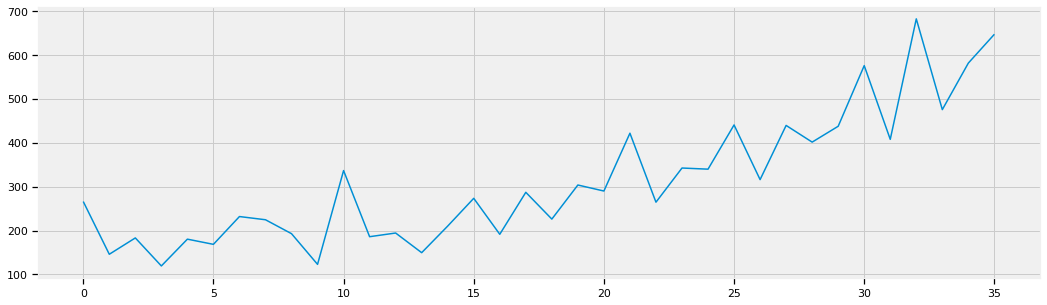

In [5]:
sales.plot(figsize=(16,5))

In [6]:
X1 = sales.index.values
Y1 = sales.values
X1.shape, Y1.shape

((36,), (36,))

In [7]:
import numpy as np
from sklearn.linear_model import LinearRegression

X = X1.reshape(-1, 1)
Y = Y1.reshape(-1, 1)
reg = LinearRegression().fit(X, Y)

reg.coef_

array([[12.07907336]])

In [8]:
reg.intercept_

array([101.21621622])

In [9]:
Y_reg = 12.08 * X1 + 101.22

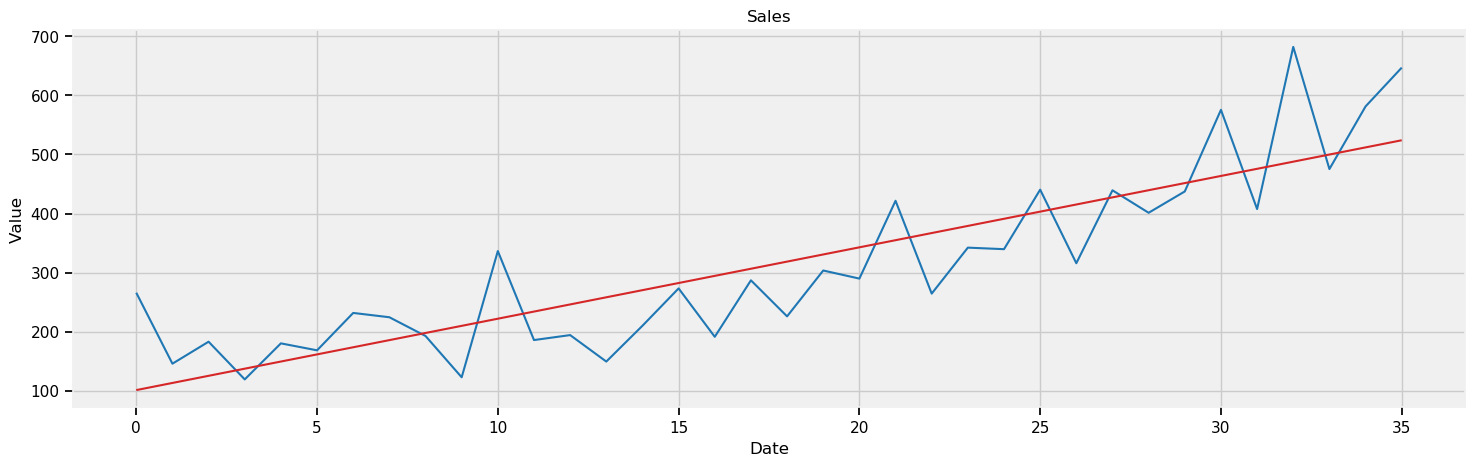

In [10]:
def plot_df(x, y, y_reg, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.plot(x, y_reg, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(x=X1, y=Y1, y_reg=Y_reg, title='Sales') 

In [11]:
import pymc3 as pm

with pm.Model() as model:
    std = pm.Uniform("std", 0, 100)
    
    beta = pm.Normal("beta", mu=12, sd=10)
    alpha = pm.Normal("alpha", mu=101, sd=10)
    
    mean = pm.Deterministic("mean", alpha + beta * X)
    
    obs = pm.Normal("obs", mu=mean, sd=std, observed=Y)
    
    trace = pm.sample(100000, step=pm.Metropolis())
    burned_trace = trace[20000:]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
>Metropolis: [std]


Sampling 4 chains for 1_000 tune and 100_000 draw iterations (4_000 + 400_000 draws total) took 69 seconds.
The number of effective samples is smaller than 25% for some parameters.


/Users/yuhuang/anaconda3/envs/deeplearning/lib/python3.7/site-packages/pymc3/plots/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))
/Users/yuhuang/anaconda3/envs/deeplearning/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13d4f8590>,
      dtype=object)

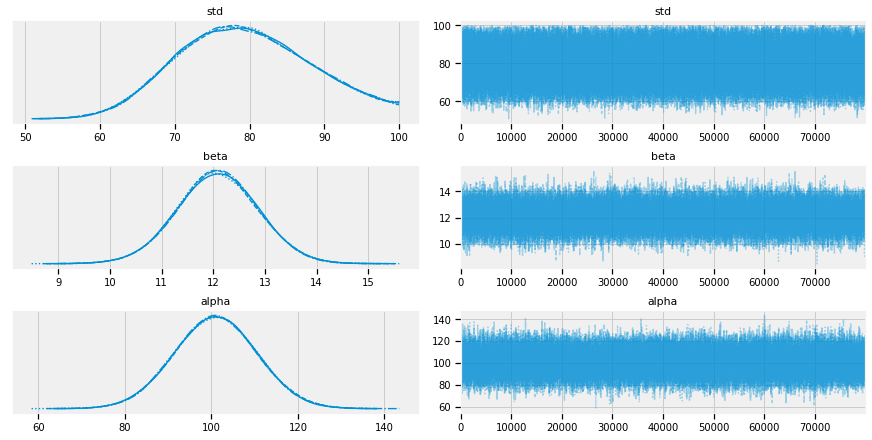

In [12]:
# pm.plots.traceplot(trace=burned_trace, varnames=["std", "beta", "alpha"])
pm.plots.traceplot(burned_trace, varnames=["std", "beta", "alpha"])

/Users/yuhuang/anaconda3/envs/deeplearning/lib/python3.7/site-packages/pymc3/plots/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))
/Users/yuhuang/anaconda3/envs/deeplearning/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x13d7a3e50>,
      dtype=object)

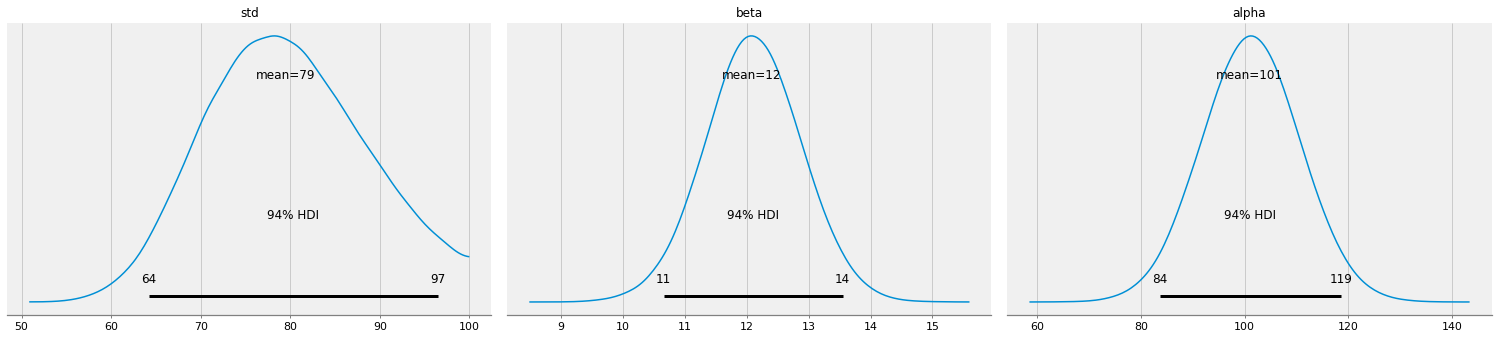

In [13]:
# pm.plot_posterior(trace=burned_trace, varnames=["std", "beta", "alpha"], kde_plot=True)
pm.plot_posterior(burned_trace, varnames=["std", "beta", "alpha"])

In [14]:
std_trace = burned_trace['std']
beta_trace = burned_trace['beta']
alpha_trace = burned_trace['alpha']

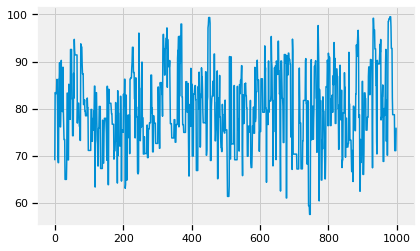

In [15]:
pd.Series(std_trace[:1000]).plot()

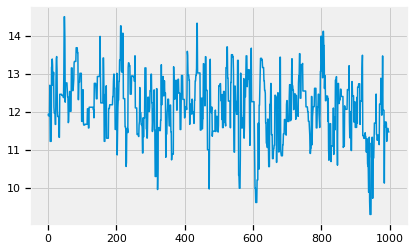

In [16]:
pd.Series(beta_trace[:1000]).plot()

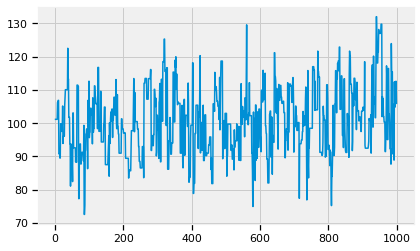

In [17]:
pd.Series(alpha_trace[:1000]).plot()

In [18]:
std_mean = std_trace.mean()
std_mean

79.43485515905014

In [19]:
beta_mean = beta_trace.mean()
beta_mean

12.085630977663552

In [20]:
alpha_mean = alpha_trace.mean()
alpha_mean

101.0025611904585

In [21]:
length = 72

In [22]:
x1 = np.arange(length)

In [23]:
mean_trace = alpha_mean + beta_mean * x1

In [24]:
normal_dist = pm.Normal.dist(0, sd=std_mean)
errors = normal_dist.random(size=length)
type(errors)

numpy.ndarray

In [25]:
Y_gen = mean_trace + errors

In [26]:
len(Y_gen)

72

In [27]:
Y_reg1 = mean_trace # beta_mean * x1 + alpha_mean # 12.08 * x1 + 101.22

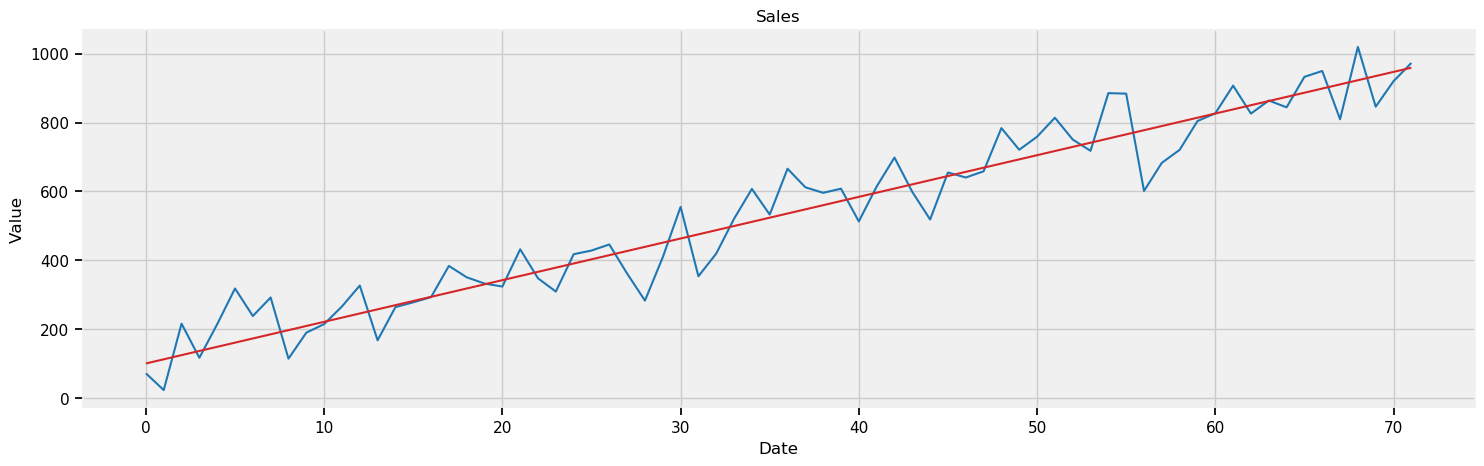

In [28]:
plot_df(x=x1, y=Y_gen, y_reg=Y_reg1, title='Sales') 